In [11]:
#Setup

#Python
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.teaching import *

#Core Includes
from rosetta.core.kinematics import MoveMap
from rosetta.core.kinematics import FoldTree
from rosetta.core.pack.task import TaskFactory
from rosetta.core.pack.task import operation
from rosetta.core.simple_metrics import metrics
from rosetta.core.select import residue_selector as selections
from rosetta.core import select
from rosetta.core.select.movemap import *

#Protocol Includes
from rosetta.protocols import minimization_packing as pack_min
from rosetta.protocols import relax as rel
from rosetta.protocols.antibody.residue_selector import CDRResidueSelector
from rosetta.protocols.antibody import *
from rosetta.protocols.loops import *

import random
import math
from pyrosetta.rosetta.core.fragment import *
from pyrosetta.rosetta.protocols.simple_moves import ClassicFragmentMover

import matplotlib.pyplot as plt

init()

PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python38.ubuntu 2022.05+release.b3365a12916d9c125d41cdee36639019f73be202 2022-02-03T16:09:08] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python38.ubuntu r310 2022.05+release.b3365a12916 b3365a12916d9c125d41cdee36639019f73be202 http://www.pyrosetta.org 2022-02-03T16:09:08
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.8/dist-packages/pyrosetta-2022.5+release.b3365a12916-py3.8-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1425735184 seed_offset=0 real_seed=1425735184
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1425735184 RG_type=mt19937


In [12]:
aa_list = ["A", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"] #not including cysteine (similar to resfile)
pose_1 = pyrosetta.pose_from_pdb("selicase_form1.pdb") 
pose_2 = pyrosetta.pose_from_pdb("selicase_form2.pdb")
sfxn = get_fa_scorefxn()

def pack(pose):
    '''rotamer packing'''
    bb = Pose()
    bb.assign(pose)
    tf = TaskFactory()
    tf.push_back(operation.InitializeFromCommandline())
    tf.push_back(operation.RestrictToRepacking())
    packer = pack_min.PackRotamersMover(sfxn)
    packer.task_factory(tf)   
    if not os.getenv("DEBUG"):
        packer.apply(bb)
    return bb

def high_res(your_pose, move_map, KT):
    '''do high res refinement'''
    #full atom (best representation) score function
    sfxn_ssm = pyrosetta.get_fa_scorefxn()
    small_mover = SmallMover(move_map, KT, 1)
    shear_mover = ShearMover(move_map, KT, 1)
    min_mover = MinMover()

    small_mover.angle_max("H", 3)
    small_mover.angle_max("E", 5)
    small_mover.angle_max("L", 6)

    shear_mover.angle_max("H", 3)
    shear_mover.angle_max("E", 5)
    shear_mover.angle_max("L", 6)

    mc_ssm = MonteCarlo(your_pose, sfxn_ssm, KT)
    small_trial = TrialMover(small_mover, mc_ssm)
    shear_trial = TrialMover(shear_mover, mc_ssm)
    min_trial = TrialMover(min_mover, mc_ssm)

    seq_mover = SequenceMover()
    seq_mover.add_mover(small_trial)
    seq_mover.add_mover(shear_trial)
    seq_mover.add_mover(min_trial)

    ssm_tries = 100

    ssm_repeats = RepeatMover(seq_mover, ssm_tries)
    ssm_repeats.apply(your_pose)
    return your_pose

def high_res_score(your_pose):
    '''create high resolution score function'''
    sfxn =  pyrosetta.get_fa_scorefxn()
    return sfxn(your_pose)

def mutate(pose1, pose2):
    '''main function for mutating each individual residue'''
    KT = 1
    move_map = MoveMap()
    move_map.set_bb(True)# allow backbone movements
    delg_ref = abs(high_res_score(pose1) - high_res_score(pose2)) #comparison between delg of the two original forms
    copy1 = Pose()
    copy1.assign(pose1)
    copy2 = Pose()
    copy2.assign(pose2)
    test1 = Pose() #work with test and copied poses
    test1.assign(pose1)
    test2 = Pose()
    test2.assign(pose2)
    for i in range(2, 20): #aa range of high IDDT sequence
        for aa in aa_list:
            toolbox.mutants.mutate_residue(test1, i, aa) #mutate residues 
            toolbox.mutants.mutate_residue(test2, i, aa)
            test1.assign(high_res(test1, move_map, KT)) #slight refinement
            test2.assign(high_res(test2, move_map, KT))
            test1.assign(pack(test1)) #rotamer packing
            test2.assign(pack(test2))
            delg_comp = abs(high_res_score(test1) - high_res_score(test2)) #check the new delg
            deldelg = delg_comp - delg_ref #check new difference between delgs
            if deldelg < 0: #if the energy is closer together
                copy1.assign(test1) #set the copies equal to the tests
                copy2.assign(test2)
                delg_ref = abs(high_res_score(copy1) - high_res_score(copy2)) #new reference
            else:
                test1.assign(copy1) #if the energy is not closer, go back to the old pose
                test2.assign(copy2)
    return (copy1, copy2)

ssm_mutant = mutate(pose_1, pose_2)
ssm_mutant[0].dump_pdb("ssm_mutant_form1.pdb")
ssm_mutant[1].dump_pdb("ssm_mutant_form2.pdb")
            


core.import_pose.import_pose: File 'selicase_form1.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 108
core.import_pose.import_pose: File 'selicase_form2.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 108
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.pack.task: Packer task: initialize from command line()
core.pack.pack_rotamers: built 1 rotam

KeyboardInterrupt: 

In [9]:
#score validation
print(sfxn(ssm_mutant[0]))
print(sfxn(ssm_mutant[1]))

-154.32140408778983
-154.95147035601434


core.import_pose.import_pose: File 'ssm_mutant_form1.pdb' automatically determined to be of type PDB
core.import_pose.import_pose: File 'ssm_mutant_form2.pdb' automatically determined to be of type PDB
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: SCOREFUNC

Text(0, 0.5, 'Energy')

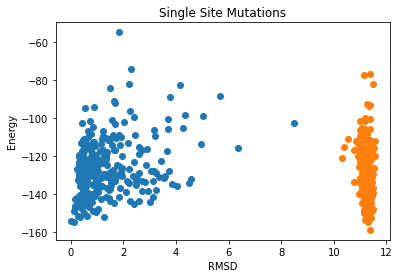

In [14]:
#validation; this is the same code as the energy_landscape code

poses1 = []
poses2 = []
pose_1 = pyrosetta.pose_from_pdb("ssm_mutant_form1.pdb")
pose_2 = pyrosetta.pose_from_pdb("ssm_mutant_form2.pdb")

def landscape(pose, poses):
    KT = 5
    move_map = MoveMap()
    move_map.set_bb(True)
    move_map.set_chi(True)
    move_map.set_jump(True)
    poses.append(pose)
    for i in range(0, 300):
        copy_pose = Pose()
        copy_pose.assign(pose)
        alter_pose = Pose()
        alter_pose.assign((high_res(copy_pose, move_map, KT)))
        poses.append(alter_pose)
    
def high_res_score(your_pose):
    '''create high resolution score function'''
    sfxn =  pyrosetta.get_fa_scorefxn()
    return sfxn(your_pose)

def high_res(your_pose, move_map, KT):
    '''do high res movements/functional equivalent of FastRelax'''
    #full atom (best representation) score function
    sfxn_ssm = pyrosetta.get_fa_scorefxn()
    small_mover = SmallMover(move_map, KT, 1)
    shear_mover = ShearMover(move_map, KT, 1)
    min_mover = MinMover()

    small_mover.angle_max("H", 180)
    small_mover.angle_max("E", 180)
    small_mover.angle_max("L", 180)

    shear_mover.angle_max("H", 180)
    shear_mover.angle_max("E", 180)
    shear_mover.angle_max("L", 180)

    mc_ssm = MonteCarlo(your_pose, sfxn_ssm, KT)
    small_trial = TrialMover(small_mover, mc_ssm)
    shear_trial = TrialMover(shear_mover, mc_ssm)
    min_trial = TrialMover(min_mover, mc_ssm)

    seq_mover = SequenceMover()
    seq_mover.add_mover(small_trial)
    seq_mover.add_mover(shear_trial)
    seq_mover.add_mover(min_trial)

    ssm_tries = 100

    ssm_repeats = RepeatMover(seq_mover, ssm_tries)
    ssm_repeats.apply(your_pose)
    return your_pose

    
    
rmsds1 = []
energies1 = []

rmsds2 = []
energies2 = []
landscape(pose_1, poses1)
landscape(pose_2, poses2)
for i in range(0, len(poses1)):
    rmsds1.append(pyrosetta.rosetta.core.scoring.CA_rmsd(pose_1, poses1[i]))

for i in range(0, len(poses1)):
    energies1.append(high_res_score(poses1[i]))


#compare to pose1 to get relative energy score
for i in range(0, len(poses2)):
    rmsds2.append(pyrosetta.rosetta.core.scoring.CA_rmsd(pose_1, poses2[i]))

for i in range(0, len(poses2)):
    energies2.append(high_res_score(poses2[i]))

plt.scatter(rmsds1, energies1)
plt.scatter(rmsds2, energies2)
plt.title("Single Site Mutations")
plt.xlabel("RMSD")
plt.ylabel("Energy")
